In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

## 1. load temperature data and add time features

In [112]:
folder_Data = "../../data/ECA_blended_custom(6)/"
with open(file=folder_Data + "TG_STAID002759.txt", mode = 'r') as file:
    df_raw = pd.read_csv(file, sep=',', header='infer', skiprows=19)

## 2. Impute data

In [113]:
# get rid of leading whitespaces in headers
df_raw.columns = ['SOUID', 'DATE', 'TG', 'Q_TG']

# Add the missing values by taking the mean of the temperature of the same day one year earlier and later
missing_value_mask = (df_raw['Q_TG'] == 9)
next_year_mask = (df_raw.loc[df_raw['Q_TG'] == 9].index + 365)
previous_year_mask = (df_raw.loc[df_raw['Q_TG'] == 9].index - 365)
df_raw['TG'].loc[missing_value_mask] = (df_raw['TG'].iloc[next_year_mask].values + df_raw['TG'].iloc[previous_year_mask].values) / 2

## 3. Feature engineering

In [114]:
# create the timesteps
df_raw['timestep'] = list(range(df_raw.shape[0]))
# convert date to DATETIME
df_raw['DATETIME'] = pd.to_datetime(df_raw['DATE'],format="%Y%m%d")
# create month feature
df_raw['MONTH'] = df_raw['DATETIME'].dt.month
# divide the temperature by 10
df_raw['TG'] = df_raw['TG'].apply(lambda x: x / 10)
df_raw.head(5)

,SOUID,DATE,TG,Q_TG,timestep,DATETIME,MONTH
0,127488,18760101,2.2,0,0,1876-01-01,1
1,127488,18760102,2.5,0,1,1876-01-02,1
2,127488,18760103,0.3,0,2,1876-01-03,1
3,127488,18760104,-5.8,0,3,1876-01-04,1
4,127488,18760105,-9.8,0,4,1876-01-05,1


In [115]:
# add the month dummies
df_raw = pd.get_dummies(data=df_raw, prefix=['month'], columns=['MONTH'], drop_first=True)

<AxesSubplot:>

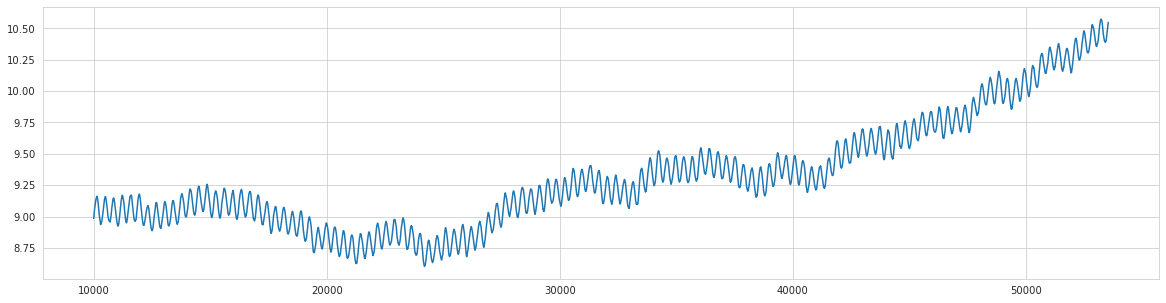

In [116]:
# check the degree of the ploynome by the moving average
plt.subplots(figsize= (20,5))
df_raw['TG'].rolling(10000).mean().plot()
# 4 maxima detected --> take degree=5

In [117]:
# create a copy of the dataset to drop some columns and set the datetime as index
df_full = df_raw.copy()
df_full.set_index('DATETIME', inplace=True)
df_full.drop(columns=['DATE', 'SOUID', 'DATE', 'Q_TG'], inplace=True)
df_full.head(3)

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATETIME,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0


## 4. Create a trend-saisonal-model

In [118]:
# Train the model with trend and saisonal features
X = df_full.drop(columns='TG')
y = df_full['TG']
mod_trend_saison = LinearRegression()
mod_trend_saison.fit(X,y)
mod_trend_saison.coef_


array([3.35053924e-05, 9.54373214e-01, 4.17084798e+00, 8.83240415e+00,
       1.39279000e+01, 1.73260519e+01, 1.90170895e+01, 1.82665537e+01,
       1.44818457e+01, 9.47014403e+00, 4.55740463e+00, 1.33727829e+00])

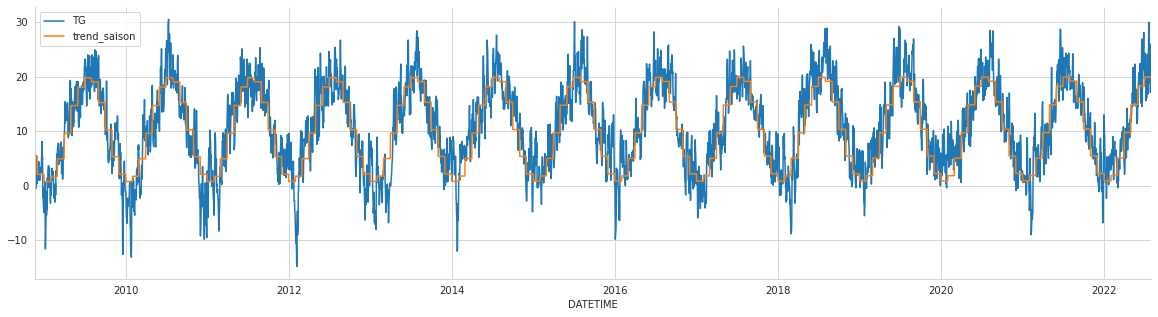

In [119]:
# add the trend and saisonal to the DF and plot the temperatures and prediction
df_full['trend_saison'] = mod_trend_saison.predict(X)
df_full[['TG','trend_saison']][-5000:].plot(figsize=(20,5),legend=True)
sns.despine()

## 5. Explore the remainder

<AxesSubplot:xlabel='DATETIME'>

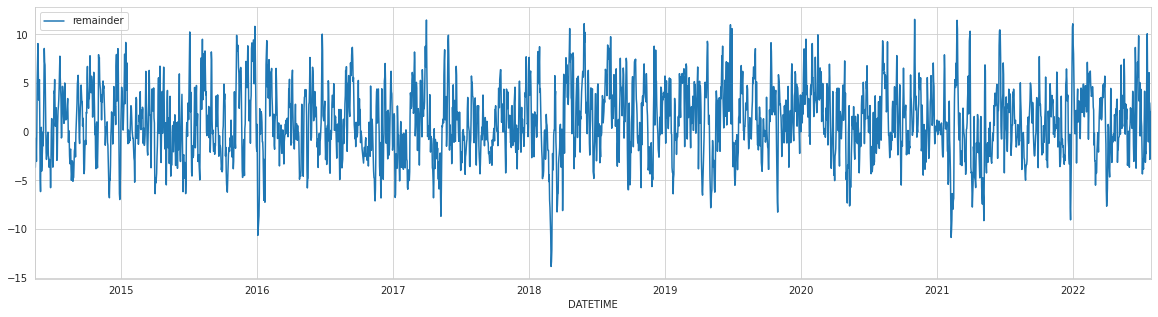

In [120]:
# calculate and plot the remainder
df_full['remainder'] = df_full['TG'] - df_full['trend_saison']
df_full['remainder'][-3000:].plot(figsize=(20,5),legend=True)

/home/thorsten/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


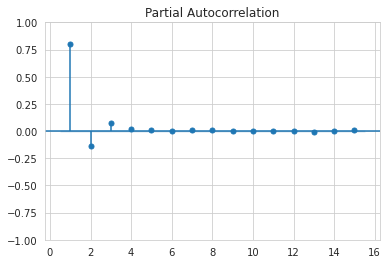

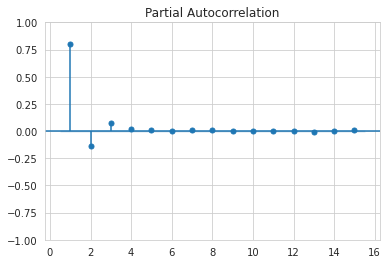

In [121]:
# plot the partial autocorrelation
plot_pacf(df_full['remainder'], lags=15, zero=False)

In [122]:
# test the remainder for stationarity
print(adfuller(df_full['remainder']))


(-23.833809444501902, 0.0, 58, 53479, {'1%': -3.430472283773219, '5%': -2.8615940469938717, '10%': -2.56679876741385}, 241107.9357881468)


## 6. add the remainder timelags

In [123]:
# create two timelags
no_lags = 2
# add lags to df
lag_columns = []
for i in range(no_lags):
    lag_columns.append('lag' + str(i + 1))
    df_full[lag_columns[i]] = df_full['remainder'].shift(i + 1)
df_full.dropna(inplace=True)

## 7. Train and evaluate a linear model

<AxesSubplot:xlabel='DATETIME'>

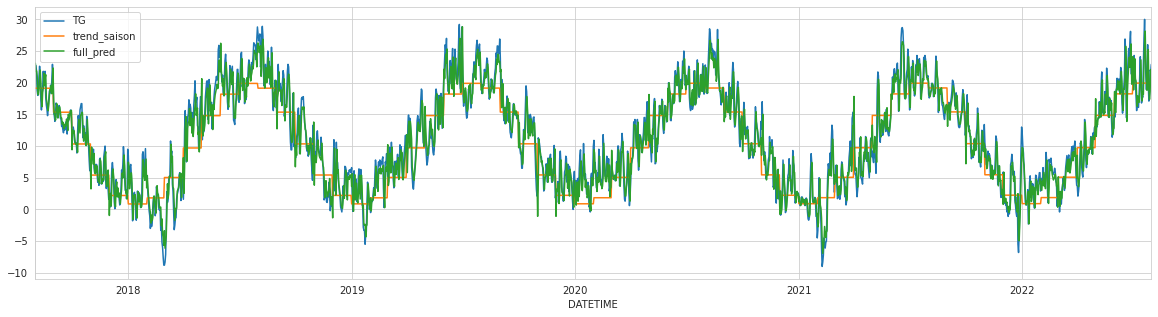

In [124]:
# leave timesteps, month (ohe) and remainder timelags as train data
X_full = df_full.drop(columns= ['TG', 'trend_saison', 'remainder'])
y_full = df_full['TG']
# fit the full model
mod_full = LinearRegression()
mod_full.fit(X_full, y_full)
# plot the temperature, the trend & saison prediction and the full prediction
df_full['full_pred'] = mod_full.predict(X_full)
df_full[['TG','trend_saison', 'full_pred']][-1825:].plot(figsize=(20,5),legend=True)


In [125]:
# evaluate the model with cross validation
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X_full, y_full)
result = cross_val_score(estimator=mod_full, X=X_full, y=y_full, cv=time_series_split)
result

array([0.90429754, 0.9126261 , 0.91401241, 0.90794311, 0.91784427])

## 8. predict future temperature

In [126]:
# create future row (1 day)
timestep = df_full['timestep'].max() + 1
month = [0]*6 + [1] + [0]*4
lag1 = df_full['remainder'][-1:].values[0]
lag2 = df_full['remainder'][-2:-1].values[0]
X_future = [timestep]
X_future.extend(month)
X_future.append(lag1)
X_future.append(lag2)
X_future = pd.DataFrame([X_future])
X_future.columns = X_full.columns
X_future


,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2
0,53538,0,0,0,0,0,0,1,0,0,0,0,2.963167,1.8632


In [127]:
mod_full.predict(X_future)
# real mean temp 21.3

array([21.59310408])

In [128]:
X_future2=[timestep + 1]
X_future2.extend(month)
X_future2.append(21.3 - 21.59310408)
X_future2.append(2.963167)
X_future2 = pd.DataFrame([X_future2])
X_future2.columns = X_future.columns
X_future2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2
0,53539,0,0,0,0,0,0,1,0,0,0,0,-0.293104,2.963167


In [129]:
mod_full.predict(X_future2)
# real mean temp 22.5

array([18.47964681])

## 9. Compare with alternative model (with polynomial features)

In [130]:
# add polynomials of degree 2 (here only degree 2 as there is no increase in accuracy with more)
poly = PolynomialFeatures(degree=2, interaction_only=False)
poly_dt = poly.fit_transform(X_full[['timestep']])
df_poly_dt = pd.DataFrame(data=poly_dt, index= X_full.index, columns = poly.get_feature_names_out())
df_poly_dt.drop(columns=['1', 'timestep'], inplace=True)
X_poly = pd.concat([X_full, df_poly_dt], axis=1)

In [131]:
# train the model
mod_lin_poly = LinearRegression()
mod_lin_poly.fit(X_poly, y_full)


LinearRegression()

In [132]:
# evaluate the model with cross validation
ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X_poly, y_full)
result = cross_val_score(estimator=mod_lin_poly, X=X_poly, y=y_full, cv=time_series_split)
result

array([0.88011009, 0.91106667, 0.9141304 , 0.90804998, 0.91854208])

In [133]:
X_future['timestep^2'] = X_future['timestep']**2
mod_lin_poly.predict(X_future)

array([21.74945885])